In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import scipy.optimize as opt

import cofiCostFunction as ccf
import checkCostFunction as cf
import loadMovieList as lm
import normalizeRatings as nr


In [2]:

plt.ion()
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [3]:
# ===================== Part 1: Loading movie ratings dataset =====================
# We will start by loading the movie ratings dataset to understand the
# structure of the data
print('Loading movie ratings dataset.')

# Load data
data = scio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

# Y is a 1682 x 943 2-d ndarray, containing ratings 1-5 of 1682 movies on 943 users
#
# R is a 1682 x 943 2-d ndarray, where R[i, j] = 1 if and only if user j gave a
# rating to movie i

Loading movie ratings dataset.


In [4]:
# From the matrix, we can compute statistics like average rating.
print('Average ratings for movie 0(Toy Story): {:0.6f}/5'.format(np.mean(Y[0, np.where(R[0] == 1)])))

Average ratings for movie 0(Toy Story): 3.878319/5


Text(0, 0.5, 'Movies')

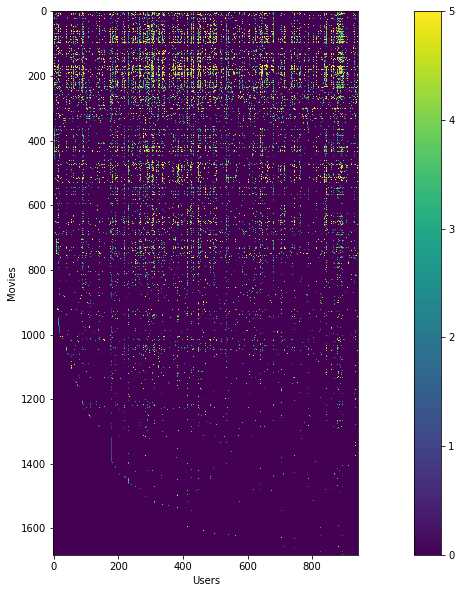

In [5]:
# We can visualize the ratings matrix by plotting it with plt.imshow
plt.figure(figsize=(20, 10))
plt.imshow(Y)
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

In [6]:
# ===================== Part 2: Collaborative Filtering Cost function =====================
# You will now implement the cost function for collaborative filtering.
# To help you debug your cost function, we have included set of weights
# that we trained on that. Specifically, you should complete the code in
# cofiCostFunc.py to return cost.
#

# Load pre-trained weights (X, theta, num_users, num_movies, num_features)
data = scio.loadmat('ex8_movieParams.mat')
X = data['X']
theta = data['Theta']
num_users = data['num_users'][0,0]
num_movies = data['num_movies'][0,0]
num_features = data['num_features'][0,0]

In [7]:
# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
theta = theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

In [8]:
lmd = 1.5

In [9]:
def cofi_cost_function(params, Y, R, num_users, num_movies, num_features, lmd):
    X = params[0:num_movies * num_features].reshape((num_movies, num_features))
    theta = params[num_movies * num_features:].reshape((num_users, num_features))

    # You need to set the following values correctly.
    cost = 0
    X_grad = np.zeros(X.shape)
    theta_grad = np.zeros(theta.shape)

    # ===================== Your Code Here =====================
    # Instructions: Compute the cost function and gradient for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. After that, you should implement the
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies x num_features matrix of movie features
    #        theta - num_users x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R[i, j] = 1 if the
    #        i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly
    #
    #        X_grad - num_movies x num_features matrix, containing the
    #                 partial derivatives w.r.t. to each element of X
    #        theta_grad - num_users x num_features matrix, containing the
    #                     partial derivatives w.r.t. to each element of theta


    cost = np.sum(np.power(((theta @ X.T).T - Y) * R, 2)) / 2 + lmd * np.sum(np.power(theta, 2)) / 2 + lmd * np.sum(np.power(X, 2)) / 2
    theta_grad += (((theta @ X.T).T - Y) * R).T @ X + lmd * theta
    X_grad += (((theta @ X.T).T - Y) * R) @ theta + lmd * X
    # ==========================================================

    grad = np.concatenate((X_grad.flatten(), theta_grad.flatten()))

    return cost, grad


In [10]:
# Evaluate cost function
cost, grad = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, 0)

print('Cost at loaded parameters: {:0.2f}\n(this value should be about 22.22)'.format(cost))


Cost at loaded parameters: 22.22
(this value should be about 22.22)


In [11]:
import computeNumericalGradient as cng

def check_cost_function(lmd):

    # Create small problem
    x_t = np.random.rand(4, 3)
    theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(x_t, theta_t.T)  # 4x5
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    x = np.random.randn(x_t.shape[0], x_t.shape[1])
    theta = np.random.randn(theta_t.shape[0], theta_t.shape[1])
    num_users = Y.shape[1]  #5
    num_movies = Y.shape[0]  #4
    num_features = theta_t.shape[1] #3

    def cost_func(p):
        return cofi_cost_function(p, Y, R, num_users, num_movies, num_features, lmd)

    numgrad = cng.compute_numerial_gradient(cost_func, np.concatenate((x.flatten(), theta.flatten())))

    cost, grad = cofi_cost_function(np.concatenate((x.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, lmd)

    print(np.c_[numgrad, grad])
    print('The above two columns you get should be very similar.\n'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient')

    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('If you backpropagation implementation is correct, then\n'
          'the relative difference will be small (less than 1e-9).\n'
          'Relative Difference: {:0.3e}'.format(diff))


In [12]:

# ===================== Part 3: Collaborative Filtering Gradient =====================
# Once your cost function matches up with ours, you should now implement
# the collaborative filtering gradient function. Specifically, you should
# complete the code in cofiCostFunction.py to return the grad argument.
#
print('Checking gradients (without regularization) ...')

# Check gradients by running check_cost_function()
check_cost_function(0)


Checking gradients (without regularization) ...
[[ 0.000000  0.000000]
 [ 0.000000  0.000000]
 [ 0.000000  0.000000]
 [-0.447814 -0.447814]
 [-3.590314 -3.590314]
 [ 0.241702  0.241702]
 [-0.609969 -0.609969]
 [-1.148636 -1.148636]
 [-1.011890 -1.011890]
 [-4.527463 -4.527463]
 [-4.725949 -4.725949]
 [ 6.679027  6.679027]
 [ 0.000000  0.000000]
 [ 0.000000  0.000000]
 [ 0.000000  0.000000]
 [-0.349269 -0.349269]
 [-0.105882 -0.105882]
 [-0.397356 -0.397356]
 [-2.504598 -2.504598]
 [-3.321788 -3.321788]
 [ 1.698649  1.698649]
 [ 2.472884  2.472884]
 [ 5.991712  5.991712]
 [-3.734202 -3.734202]
 [-0.514222 -0.514222]
 [-0.155889 -0.155889]
 [-0.585021 -0.585021]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient
If you backpropagation implementation is correct, then
the relative difference will be small (less than 1e-9).
Relative Difference: 1.131e-12


In [13]:
# ===================== Part 4: Collaborative Filtering Cost Regularization =====================
# Now, you should implement regularization for the cost function for
# collaborative filtering. You can implement it by adding the cost of
# regularization to the original cost computation.
#

# Evaluate cost function
cost, _ = cofi_cost_function(np.concatenate((X.flatten(), theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)

print('Cost at loaded parameters (lambda = 1.5): {:0.2f}\n'
      '(this value should be about 31.34)'.format(cost))

Cost at loaded parameters (lambda = 1.5): 31.34
(this value should be about 31.34)


In [14]:
# ===================== Part 5: Collaborative Filtering Gradient Regularization =====================
# Once your cost matches up with ours, you should proceed to implement
# regularization for the gradient.
#

print('Checking Gradients (with regularization) ...')

# Check gradients by running check_cost_function
check_cost_function(1.5)


Checking Gradients (with regularization) ...
[[ 9.027049  9.027049]
 [ 8.191003  8.191003]
 [ 10.550557  10.550557]
 [ 2.710384  2.710384]
 [-1.123058 -1.123058]
 [-0.186470 -0.186470]
 [ 4.620906  4.620906]
 [ 3.330302  3.330302]
 [ 2.367734  2.367734]
 [ 7.272687  7.272687]
 [ 3.154981  3.154981]
 [ 8.516820  8.516820]
 [-3.452637 -3.452637]
 [-0.886003 -0.886003]
 [-0.921775 -0.921775]
 [-23.658376 -23.658376]
 [-16.581323 -16.581323]
 [-15.657283 -15.657283]
 [-0.536484 -0.536484]
 [-1.167359 -1.167359]
 [ 1.348195  1.348195]
 [-3.082133 -3.082133]
 [ 0.585631  0.585631]
 [ 0.327981  0.327981]
 [-6.462416 -6.462416]
 [-5.635479 -5.635479]
 [-4.761054 -4.761054]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient
If you backpropagation implementation is correct, then
the relative difference will be small (less than 1e-9).
Relative Difference: 1.617e-12


In [15]:


# ===================== Part 6: Entering ratings for a new user =====================
# Before we will train the collaborative filtering model, we will first
# add ratings that correspond to a new user that we just observed. This
# part of the code will also allow you to put in your own ratings for the
# movies in our dataset!
#
movie_list = lm.load_movie_list()

# Initialize my ratings
my_ratings = np.zeros(len(movie_list))

# Check the file movie_ids.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 0, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:\n')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movie_list[i]))


New user ratings:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


In [20]:
# ===================== Part 7: Learning Movie Ratings =====================
# Now, you will train the collaborative filtering model on a movie rating
# dataset of 1682 movies and 943 users
#
print('Training collaborative filtering ...\n'
      '(this may take 1 ~ 2 minutes)')


# Load data
data = scio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by
# 943 users
#
# R is a 1682x943 matrix, where R[i,j] = 1 if and only if user j gave a
# rating to movie i

# Add our own ratings to the data matrix
Y = np.c_[my_ratings, Y]
R = np.c_[(my_ratings != 0), R]

# Normalize Ratings
Ynorm, Ymean = nr.normalize_ratings(Y, R)

# Useful values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set initial parameters (theta, X)
X = np.random.randn(num_movies, num_features)
theta = np.random.randn(num_users, num_features)

initial_params = np.concatenate([X.flatten(), theta.flatten()])

lmd = 10


def cost_func(p):
    return cofi_cost_function(p, Ynorm, R, num_users, num_movies, num_features, lmd)[0]


def grad_func(p):
    return cofi_cost_function(p, Ynorm, R, num_users, num_movies, num_features, lmd)[1]

theta, *unused = opt.fmin_cg(cost_func, fprime=grad_func, x0=initial_params, maxiter=100, disp=False, full_output=True)

# Unfold the returned theta back into U and W
X = theta[0:num_movies * num_features].reshape((num_movies, num_features))
theta = theta[num_movies * num_features:].reshape((num_users, num_features))

print('Recommender system learning completed')
print(theta)

Training collaborative filtering ...
(this may take 1 ~ 2 minutes)
Recommender system learning completed
[[-0.093326  0.017588  0.048143 ... -0.217078  0.173830  0.094081]
 [-0.506476 -0.023157  0.038491 ... -0.066189 -0.220251  0.484453]
 [-0.019166 -0.066165  0.157813 ... -0.190447 -0.333667 -0.150314]
 ...
 [ 0.095642  0.086436  0.016858 ... -0.135651  0.114671  0.083226]
 [ 0.210220  0.075431  0.097506 ... -0.648584  0.000629 -0.137795]
 [ 0.402208  0.357737 -0.100483 ...  0.184523  0.320367  0.745397]]


In [21]:
# ===================== Part 8: Recommendation for you =====================
# After training the model, you can now make recommendations by computing
# the predictions matrix.
#
p = np.dot(X, theta.T)
my_predictions = p[:, 0] + Ymean

indices = np.argsort(my_predictions)[::-1]
print('\nTop recommendations for you:')
for i in range(10):
    j = indices[i]
    print('Predicting rating {:0.1f} for movie {}'.format(my_predictions[j], movie_list[j]))

print('\nOriginal ratings provided:')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movie_list[i]))



Top recommendations for you:
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)

Original ratings provided:
Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0